In [1]:
from __future__ import print_function
%matplotlib inline
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
2017-03-22 23:04:40,068 Loading LFW people faces from /Users/salemameen/scikit_learn_data/lfw_home
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.p

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.157s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.023s


In [2]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [3]:
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
output_notebook()

Loading BokehJS ...

## Neural Networks classifier

In [4]:
import seaborn as sns
import time 
import numpy as np
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

from keras.utils import np_utils

Using Theano backend.


In [5]:
labelsTrain = np_utils.to_categorical(y_train)
labelsTest = np_utils.to_categorical(y_test) 

model = Sequential()
model.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation="softmax"))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
# Actual modelling
start_time = time.time()
model.fit(X_train_pca, labelsTrain, verbose=0, batch_size=100, nb_epoch=100)
print("The time for training NN is  %s seconds " % (time.time() - start_time))
score, accuracy = model.evaluate(X_test_pca, labelsTest, batch_size=100, verbose=0)
print("Test fraction correct (NN-Score) = {:.2f}".format(score))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

The time for training NN is  3.562169075012207 seconds 
Test fraction correct (NN-Score) = 0.64
Test fraction correct (NN-Accuracy) = 0.87


Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.080s
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.69      0.75        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.81      0.78      0.79        27
    George W Bush       0.92      0.96      0.94       146
Gerhard Schroeder       0.81      0.84      0.82        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.84      0.75      0.79        36

      avg / total       0.87      0.87      0.86       322

[[  9   1   2   0   0   0   1]
 [  2  52   0   3   0   1   2]
 [  0   2  21   3   1   0   0]
 [  0   4   2 140   0   0   0]
 [  0   2   0   1  21   0   1]
 [  0   3   0   1   1   9   1]
 [  0   1   1   4   3   0  27]]


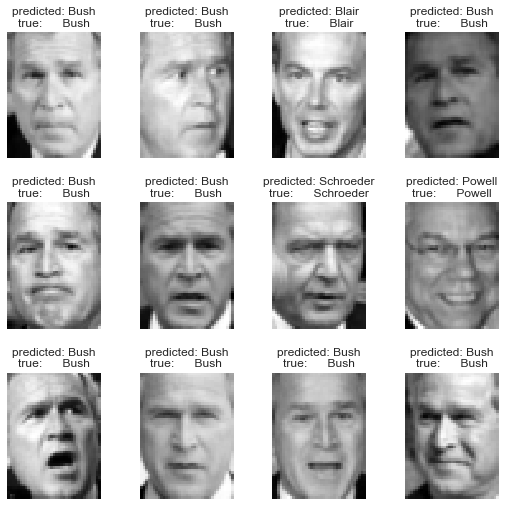

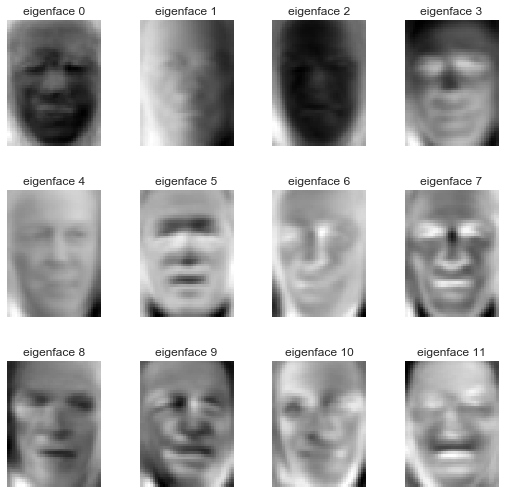

In [6]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model.predict_classes(X_test_pca)
y_pred_NN = y_pred
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

import sys
path = './face/'
sys.path.append("./face")
model.save_weights('faceModelbest.hdf5',overwrite=True)

# Multi Armed Bandit

In [7]:
import sys
#execfile("/Users/salemameen/Desktop/banditsbook/python_face/core.py")
exec(open("core.py").read())  # pyhton 3x

## Run UCB1 pruning Algorithm


Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.354188919067383 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80

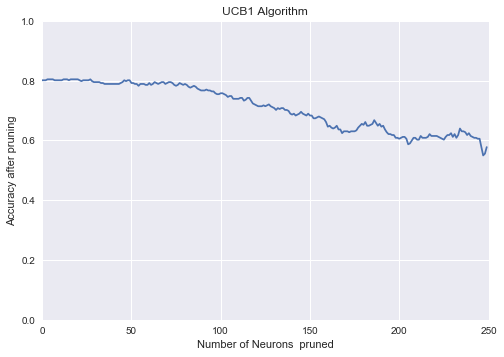

In [8]:
algo = UCB1([], [])
Alg_name = 'UCB1 Algorithm'
path = './UCB1/'
sys.path.append("./UCB1")
exec(open("mnist_cnnFORTESTING.py").read())

## Run epsilon greedy pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.2120320796966553 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.81
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.81
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.8

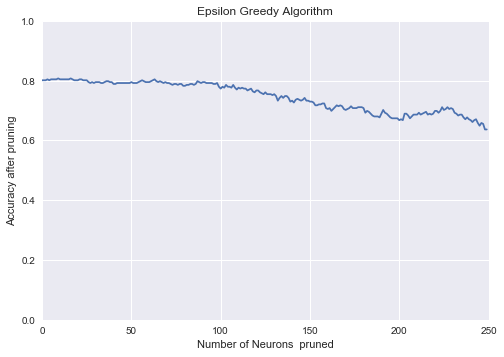

In [9]:
epsilon = 0.9 # epsilon = (0,1)
algo = EpsilonGreedy(epsilon, [], [])
Alg_name = 'Epsilon Greedy Algorithm'
path = './EpsilonGreedy/'
sys.path.append("./AnnealingEpsilonGreedy")
exec(open("mnist_cnnFORTESTING.py").read())

## Run decay epsilon greedy pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.380237102508545 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.79
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.78
Test after pruning= 0.78

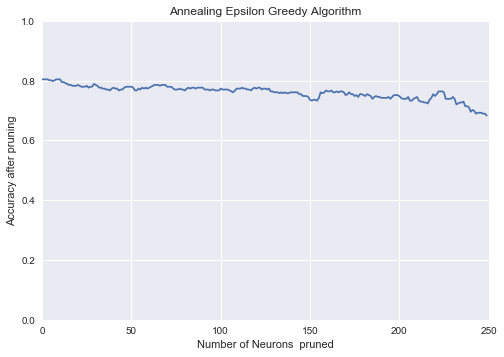

In [10]:
algo = AnnealingEpsilonGreedy([], [])
Alg_name = 'Annealing Epsilon Greedy Algorithm'
path = './AnnealingEpsilonGreedy/'
sys.path.append("./AnnealingEpsilonGreedy")
exec(open("mnist_cnnFORTESTING.py").read())

## Run softmax pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.4838831424713135 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.78
Test after pruning= 0.78
Test after pruning= 0.79
Test after pruning= 0.78
Test after pruning= 0.7

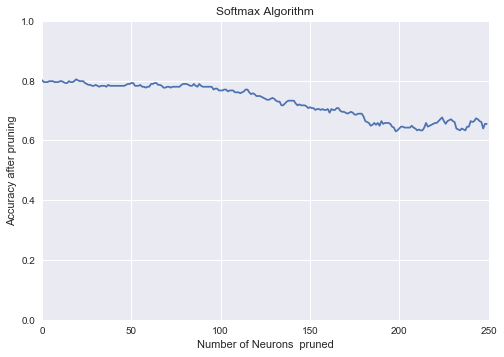

In [11]:
temperature = 0.9
algo = Softmax(temperature, [], [])
Alg_name = 'Softmax Algorithm'
path = './Softmax/'
sys.path.append("./Softmax")
exec(open("mnist_cnnFORTESTING.py").read())

## Run Decay softmax pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.429738998413086 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79

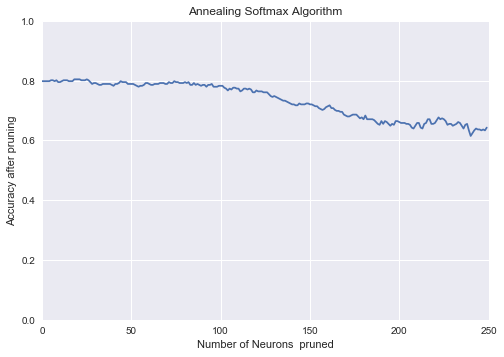

In [12]:
algo = AnnealingSoftmax([], [])
Alg_name = 'Annealing Softmax Algorithm'
path = './AnnealingSoftmax/'
sys.path.append("./AnnealingSoftmax")
exec(open("mnist_cnnFORTESTING.py").read())

## Run thompson sampling pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.5475471019744873 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.8

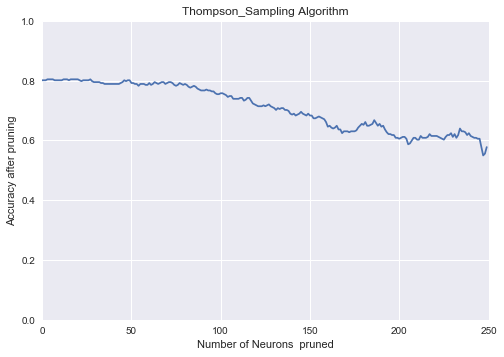

In [13]:
algo = Thompson_Sampling([], [])
Alg_name = 'Thompson_Sampling Algorithm'
path = './Thompson_Sampling/'
sys.path.append("./Thompson_Sampling")
exec(open("mnist_cnnFORTESTING.py").read())

## Run Hedge pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.3185689449310303 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.7

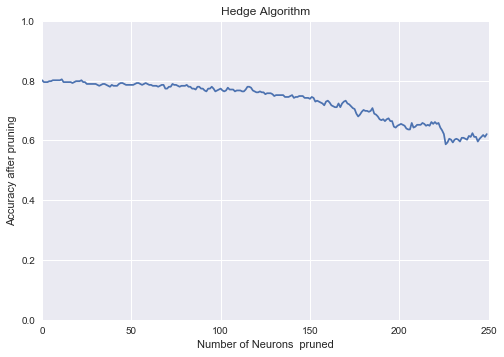

In [14]:
eta = 0.9  # eta in [.5, .8, .9, 1, 2]
algo = Hedge(eta, [], []) 
Alg_name = 'Hedge Algorithm'
path = './Hedge/'
sys.path.append("./Hedge")
exec(open("mnist_cnnFORTESTING.py").read())

## Run EXP3 pruning Algorithm

Test fraction correct (NN-Score) = 0.96
Test fraction correct (NN-Accuracy) = 0.80
The time for running this method is 2.4208500385284424 seconds 
Finsh playing start pruining:
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.81
Test after pruning= 0.81
Test after pruning= 0.81
Test after pruning= 0.81
Test after pruning= 0.81
Test after pruning= 0.81
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.80
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.79
Test after pruning= 0.7

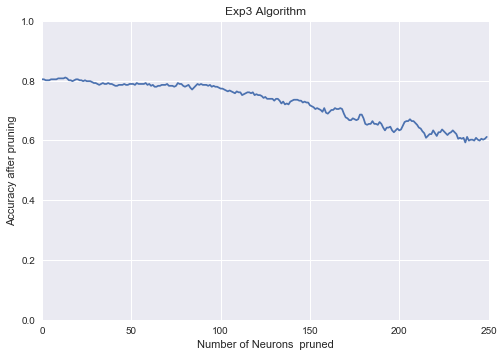

In [15]:
exp3_gamma = 0.2 #exp3_gamma in [0.1, 0.2, 0.3, 0.4, 0.5]
algo = Exp3(exp3_gamma, [])
Alg_name = 'Exp3 Algorithm'
path = './Exp3/'
sys.path.append("./EpsilonGreedy")
exec(open("mnist_cnnFORTESTING.py").read())

# Compare the accuracy of the models

In [16]:
ucb1 = np.load('./UCB1/AccuracyAftrerPrune.npy')
EpsilonGreedy = np.load('./EpsilonGreedy/AccuracyAftrerPrune.npy')
AnnealingEpsilonGreedy = np.load('./AnnealingEpsilonGreedy/AccuracyAftrerPrune.npy')
Softmax = np.load('./Softmax/AccuracyAftrerPrune.npy')
AnnealingSoftmax = np.load('./AnnealingSoftmax/AccuracyAftrerPrune.npy')
Exp3 = np.load('./Exp3/AccuracyAftrerPrune.npy')
Hedge = np.load('./Hedge/AccuracyAftrerPrune.npy')
ThompsonSampling = np.load('./Thompson_Sampling/AccuracyAftrerPrune.npy')
Accuracy = np.load('AccuracyBeforePruning.npy')

## Comparing All algorithms with the model before pruning

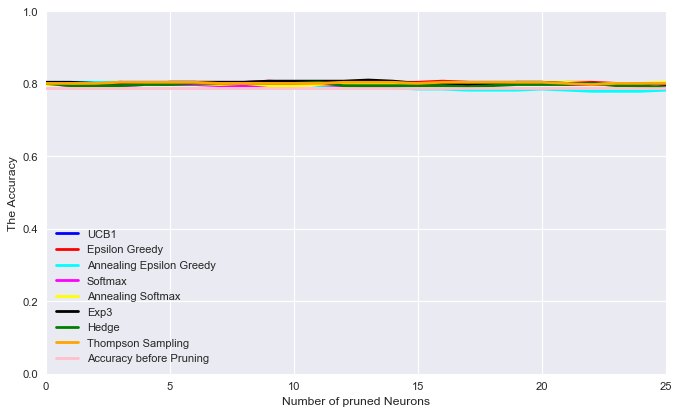

In [17]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(ucb1)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , ucb1 , color="blue", linewidth=2.5, linestyle="-", label="UCB1")
plt.plot(ind , EpsilonGreedy, color="red", linewidth=2.5, linestyle="-", label="Epsilon Greedy")
plt.plot(ind , AnnealingEpsilonGreedy, color="cyan", linewidth=2.5, linestyle="-", label="Annealing Epsilon Greedy")
plt.plot(ind , Softmax, color="magenta", linewidth=2.5, linestyle="-", label="Softmax")
plt.plot(ind , AnnealingSoftmax, color="yellow", linewidth=2.5, linestyle="-", label="Annealing Softmax")
plt.plot(ind , Exp3, color="black", linewidth=2.5, linestyle="-", label="Exp3")
plt.plot(ind , Hedge, color="green", linewidth=2.5, linestyle="-", label="Hedge")
plt.plot(ind , ThompsonSampling, color="orange", linewidth=2.5, linestyle="-", label="Thompson Sampling")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [18]:

p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)


#p1.circle(ind, ucb1, legend="ucb1", color="orange")
p1.line(ind, ucb1, legend="ucb1", line_color="orange", line_width=2)

#p1.square(ind, EpsilonGreedy, legend="Epsilon Greedy", fill_color=None, line_color="red")
p1.line(ind, EpsilonGreedy, legend="Epsilon Greedy", line_color="red", line_width=2)

#p1.ellipse(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", height=0.01, width=0.01)
p1.line(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", line_width=2)

#p1.diamond(ind, Softmax, legend="Softmax", line_color="green")
p1.line(ind, Softmax, legend="Softmax", line_color="green", line_width=2)

#p1.arc(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", end_angle= 5, radius= 0.5, start_angle= 1)
p1.line(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", line_width=2)

#p1.oval(ind, Exp3, legend="Exp3", line_color="black", height=0.01, width=0.01)
p1.line(ind, Exp3, legend="Exp3", line_color="black", line_width=2)

#p1.arc(ind, Hedge, legend="Hedge", line_color="yellow")
#p1.triangle(ind, Hedge, legend="Hedge", line_color="yellow")
p1.line(ind, Hedge, legend="Hedge", line_color="yellow", line_width=2)


#p1.square_cross(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink")
p1.line(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink", line_width=2)


p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

## UCB1

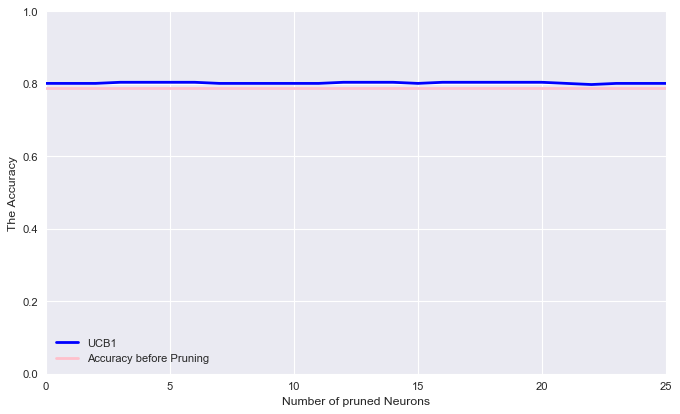

In [19]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(ucb1)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , ucb1 , color="blue", linewidth=2.5, linestyle="-", label="UCB1")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [20]:

p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)


#p1.circle(ind, ucb1, legend="ucb1", color="orange")
p1.line(ind, ucb1, legend="ucb1", line_color="orange", line_width=2)
p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a brow

## Epsilon greedy and Softmax

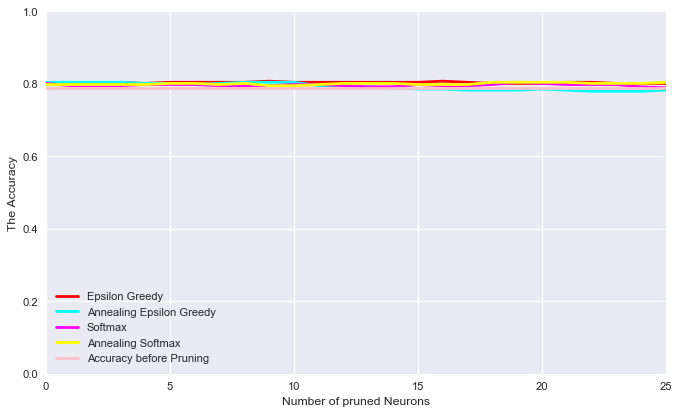

In [21]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(EpsilonGreedy)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , EpsilonGreedy, color="red", linewidth=2.5, linestyle="-", label="Epsilon Greedy")
plt.plot(ind , AnnealingEpsilonGreedy, color="cyan", linewidth=2.5, linestyle="-", label="Annealing Epsilon Greedy")
plt.plot(ind , Softmax, color="magenta", linewidth=2.5, linestyle="-", label="Softmax")
plt.plot(ind , AnnealingSoftmax, color="yellow", linewidth=2.5, linestyle="-", label="Annealing Softmax")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [22]:

p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)


#p1.square(ind, EpsilonGreedy, legend="Epsilon Greedy", fill_color=None, line_color="red")
p1.line(ind, EpsilonGreedy, legend="Epsilon Greedy", line_color="red", line_width=2)

#p1.ellipse(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", height=0.01, width=0.01)
p1.line(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", line_width=2)

#p1.diamond(ind, Softmax, legend="Softmax", line_color="green")
p1.line(ind, Softmax, legend="Softmax", line_color="green", line_width=2)

#p1.arc(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", end_angle= 5, radius= 0.5, start_angle= 1)
p1.line(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", line_width=2)

p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

## Adversial Bandits Hedge and EXP3

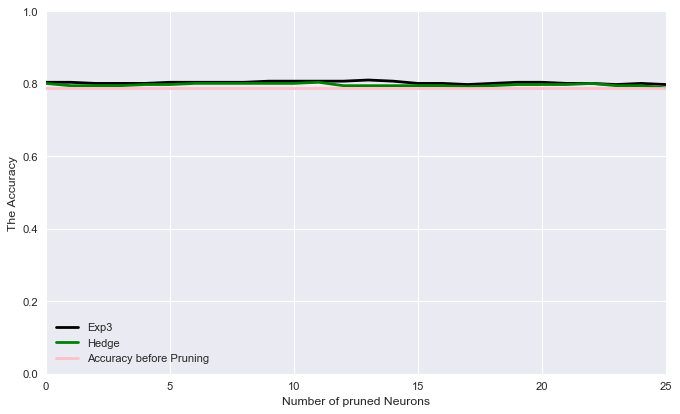

In [23]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(Exp3)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , Exp3, color="black", linewidth=2.5, linestyle="-", label="Exp3")
plt.plot(ind , Hedge, color="green", linewidth=2.5, linestyle="-", label="Hedge")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [24]:

p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)

#p1.oval(ind, Exp3, legend="Exp3", line_color="black", height=0.01, width=0.01)
p1.line(ind, Exp3, legend="Exp3", line_color="black", line_width=2)

#p1.arc(ind, Hedge, legend="Hedge", line_color="yellow")
#p1.triangle(ind, Hedge, legend="Hedge", line_color="yellow")
p1.line(ind, Hedge, legend="Hedge", line_color="yellow", line_width=2)

p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

## Thompson Sampling

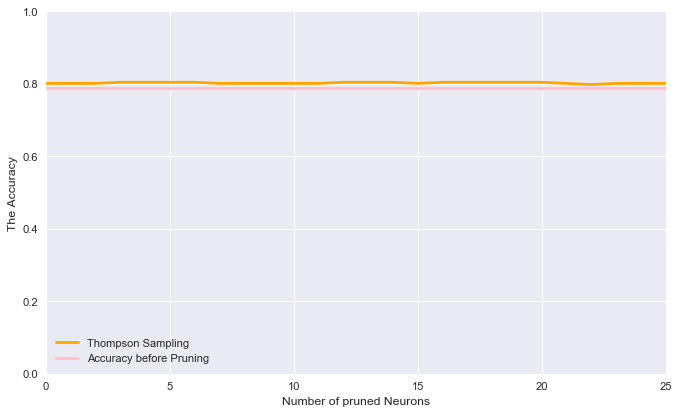

In [25]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(ThompsonSampling)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , ThompsonSampling, color="orange", linewidth=2.5, linestyle="-", label="Thompson Sampling")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [26]:

p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)

#p1.square_cross(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink")
p1.line(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink", line_width=2)


p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

## UCB1 NN after pruning

In [27]:
# MAB_NN(4%REMOVED) MODEL1 10
model1 = Sequential()
model1.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(7, activation="softmax"))
model1.load_weights('./UCB1/spam5.hdf5')
model1.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.065s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.75      0.56      0.64        27
    George W Bush       0.85      0.92      0.89       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.73      0.75      0.74        36

      avg / total       0.80      0.80      0.80       322

[[  6   2   1   3   0   0   1]
 [  1  52   0   4   1   1   1]
 [  4   3  15   3   1   0   1]
 [  1   4   3 135   0   0   3]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   2   0   7   0   0  27]]


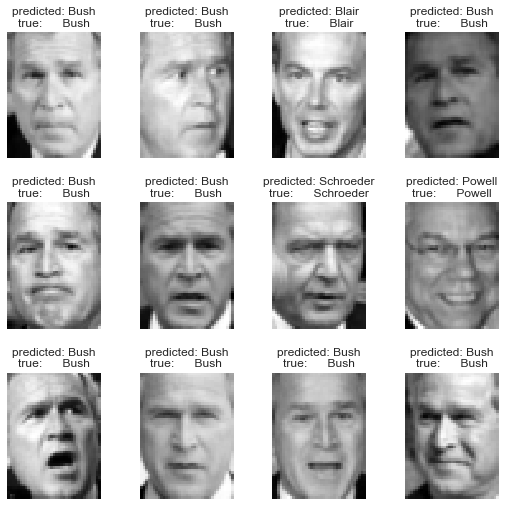

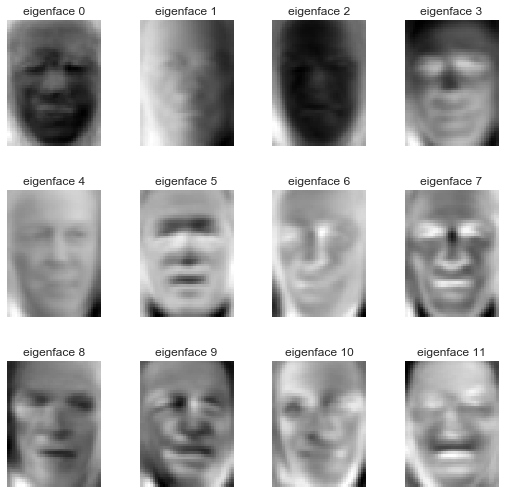

In [28]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model1.predict_classes(X_test_pca)
y_pred_NN1 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## NN after pruning 8.8%

In [29]:
# MAB_NN(8.8%REMOVED) MODEL1 22
model2 = Sequential()
model2.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(7, activation="softmax"))
model2.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/UCB1/spam20.hdf5')
model2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.062s
                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.54      0.50        13
     Colin Powell       0.78      0.83      0.81        60
  Donald Rumsfeld       0.62      0.56      0.59        27
    George W Bush       0.85      0.90      0.88       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       0.78      0.47      0.58        15
       Tony Blair       0.71      0.69      0.70        36

      avg / total       0.79      0.79      0.78       322

[[  7   1   2   2   0   0   1]
 [  1  50   1   6   0   1   1]
 [  5   3  15   3   0   0   1]
 [  1   4   5 132   0   1   3]
 [  1   1   0   2  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   3   0   6   2   0  25]]


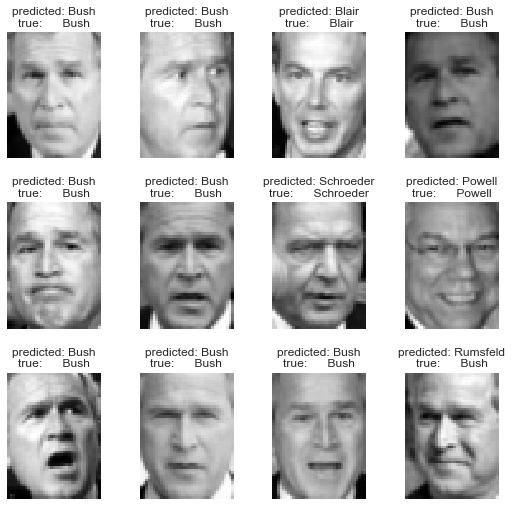

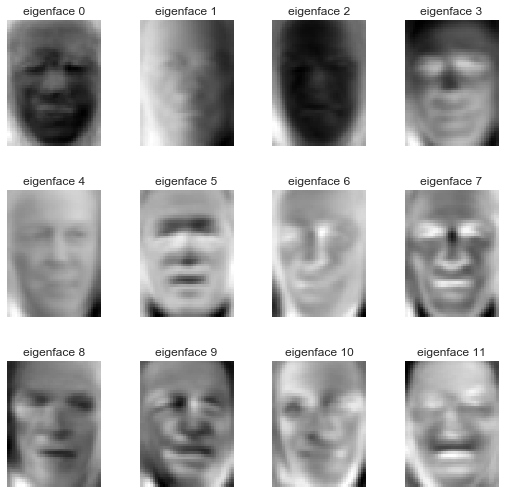

In [30]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model2.predict_classes(X_test_pca)
y_pred_NN2 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## NN after pruning 50%

In [31]:
# MAB_NN(50%REMOVED) MODEL1 125
model3 = Sequential()
model3.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(7, activation="softmax"))
model3.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/UCB1/spam124.hdf5')
model3.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.007s
                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.54      0.50        13
     Colin Powell       0.78      0.83      0.81        60
  Donald Rumsfeld       0.62      0.56      0.59        27
    George W Bush       0.85      0.90      0.88       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       0.78      0.47      0.58        15
       Tony Blair       0.71      0.69      0.70        36

      avg / total       0.79      0.79      0.78       322

[[  7   1   2   2   0   0   1]
 [  1  50   1   6   0   1   1]
 [  5   3  15   3   0   0   1]
 [  1   4   5 132   0   1   3]
 [  1   1   0   2  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   3   0   6   2   0  25]]


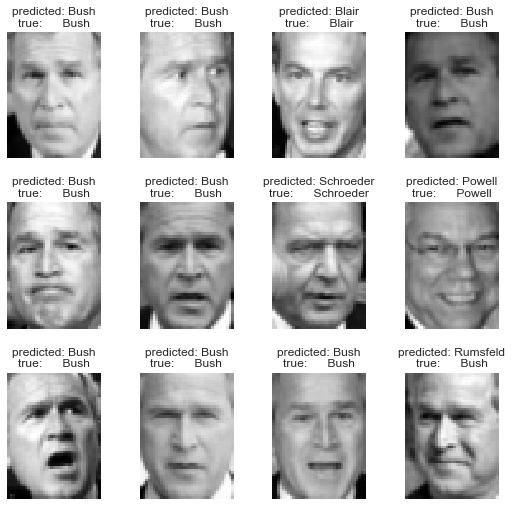

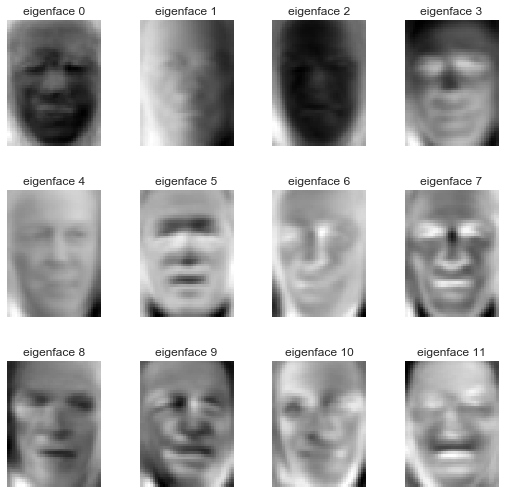

In [32]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model2.predict_classes(X_test_pca)
y_pred_NN3 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## UCB1 prune over 80%

In [33]:
model4 = Sequential()
model4.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(7, activation="softmax"))
model4.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/UCB1/spam150.hdf5')
model4.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.058s
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.31      0.40        13
     Colin Powell       0.79      0.75      0.77        60
  Donald Rumsfeld       0.44      0.70      0.54        27
    George W Bush       0.77      0.91      0.83       146
Gerhard Schroeder       0.76      0.64      0.70        25
      Hugo Chavez       1.00      0.27      0.42        15
       Tony Blair       0.94      0.44      0.60        36

      avg / total       0.77      0.74      0.72       322

[[  4   2   3   4   0   0   0]
 [  1  45   4   8   2   0   0]
 [  1   2  19   5   0   0   0]
 [  0   3   9 133   0   0   1]
 [  1   0   5   3  16   0   0]
 [  0   2   1   7   1   4   0]
 [  0   3   2  13   2   0  16]]


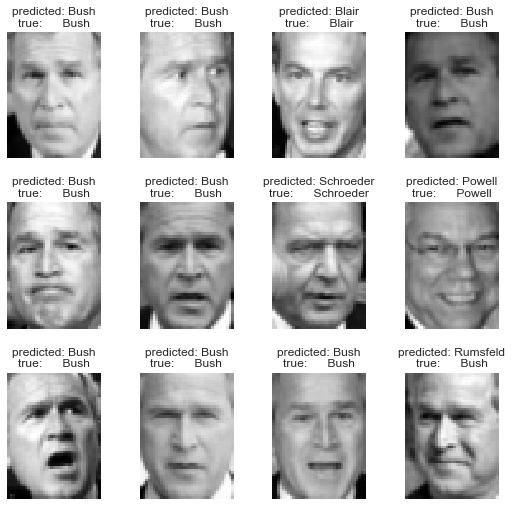

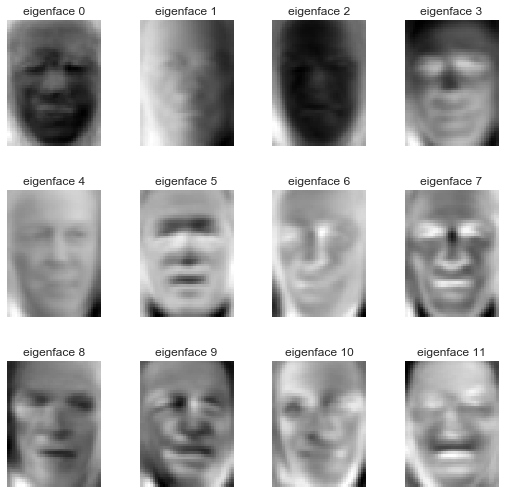

In [34]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model4.predict_classes(X_test_pca)
y_pred_NN4 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Epsilon Greedy

In [35]:
# MAB_NN(50%REMOVED) MODEL1 125
model_EG = Sequential()
model_EG.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_EG.add(Dropout(0.5))
model_EG.add(Dense(7, activation="softmax"))
model_EG.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/EpsilonGreedy/spam20.hdf5')
model_EG.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.065s
                   precision    recall  f1-score   support

     Ariel Sharon       0.40      0.46      0.43        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.62      0.56      0.59        27
    George W Bush       0.89      0.90      0.89       146
Gerhard Schroeder       0.85      0.68      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.70      0.72      0.71        36

      avg / total       0.79      0.79      0.78       322

[[  6   3   2   1   0   0   1]
 [  1  50   1   4   1   1   2]
 [  5   3  15   3   0   0   1]
 [  2   4   5 131   0   1   3]
 [  1   1   0   1  17   1   4]
 [  0   2   1   3   1   8   0]
 [  0   4   0   5   1   0  26]]


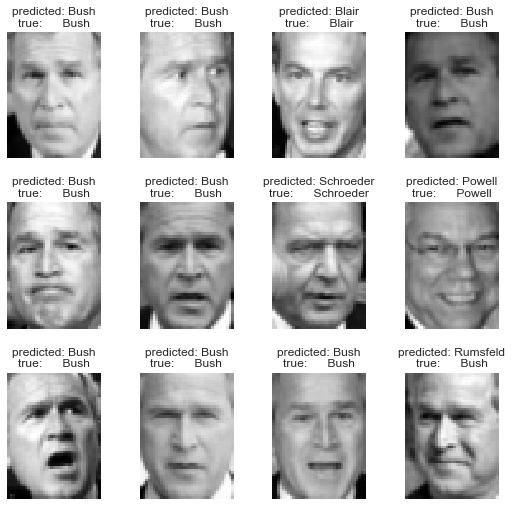

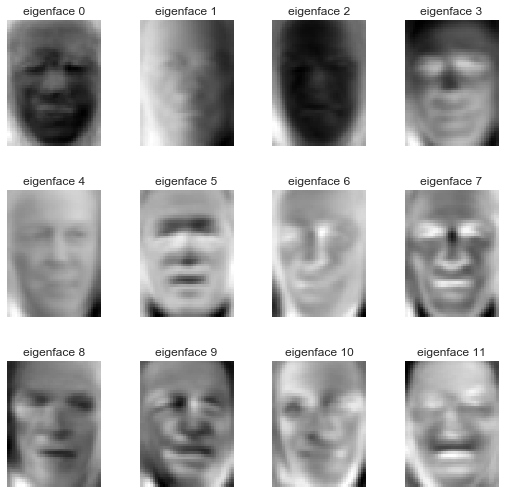

In [36]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_EG.predict_classes(X_test_pca)
y_pred_EG = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Decay  Epsilon Greedy

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.063s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.78      0.82      0.80        60
  Donald Rumsfeld       0.67      0.52      0.58        27
    George W Bush       0.86      0.91      0.88       146
Gerhard Schroeder       0.71      0.68      0.69        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.68      0.72      0.70        36

      avg / total       0.78      0.78      0.78       322

[[  6   3   2   1   0   0   1]
 [  1  49   1   4   2   1   2]
 [  4   3  14   4   1   0   1]
 [  1   4   3 133   1   0   4]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   2   0   6   2   0  26]]


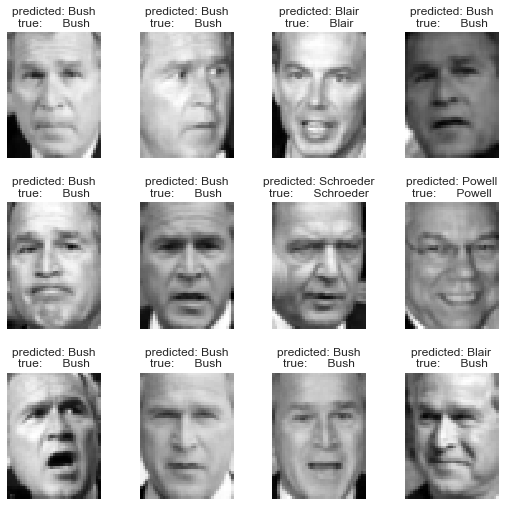

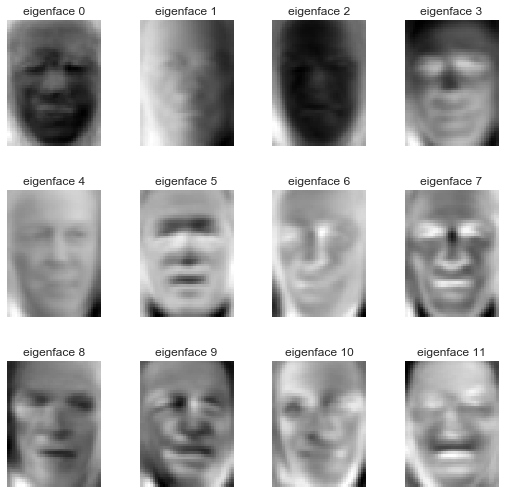

In [37]:
model_AEG = Sequential()
model_AEG.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_AEG.add(Dropout(0.5))
model_AEG.add(Dense(7, activation="softmax"))
model_AEG.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/AnnealingEpsilonGreedy/spam20.hdf5')
model_AEG.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_AEG.predict_classes(X_test_pca)
y_pred_AEG = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Softmax

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.059s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.65      0.56      0.60        27
    George W Bush       0.85      0.92      0.88       146
Gerhard Schroeder       0.77      0.68      0.72        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.69      0.61      0.65        36

      avg / total       0.78      0.78      0.77       322

[[  6   4   1   2   0   0   0]
 [  1  50   1   5   1   1   1]
 [  5   3  15   3   0   0   1]
 [  0   4   4 134   0   0   4]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   4   1   6   3   0  22]]


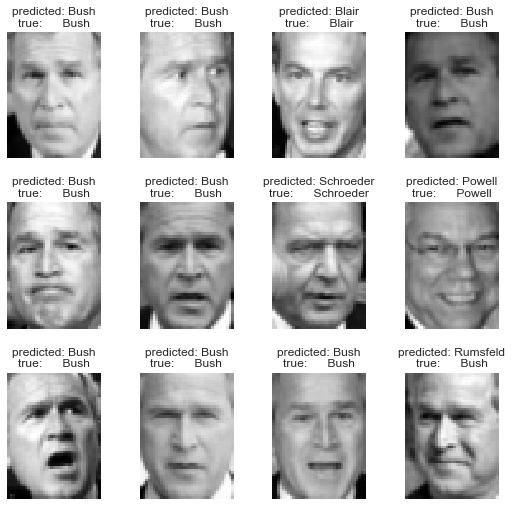

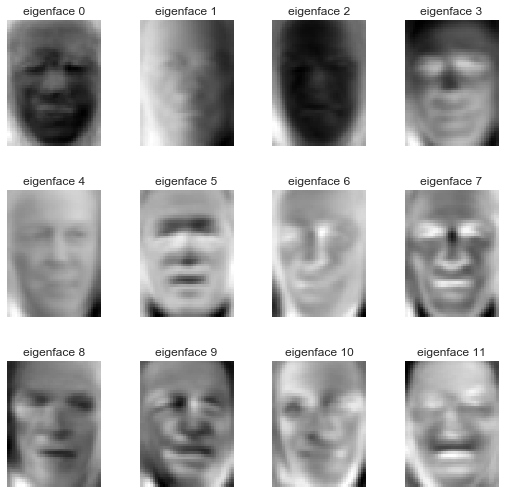

In [38]:
model_SM = Sequential()
model_SM.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_SM.add(Dropout(0.5))
model_SM.add(Dense(7, activation="softmax"))
model_SM.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/Softmax/spam20.hdf5')
model_SM.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_SM = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Decaying Softmax

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.65      0.56      0.60        27
    George W Bush       0.85      0.92      0.88       146
Gerhard Schroeder       0.77      0.68      0.72        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.69      0.61      0.65        36

      avg / total       0.78      0.78      0.77       322

[[  6   4   1   2   0   0   0]
 [  1  50   1   5   1   1   1]
 [  5   3  15   3   0   0   1]
 [  0   4   4 134   0   0   4]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   4   1   6   3   0  22]]


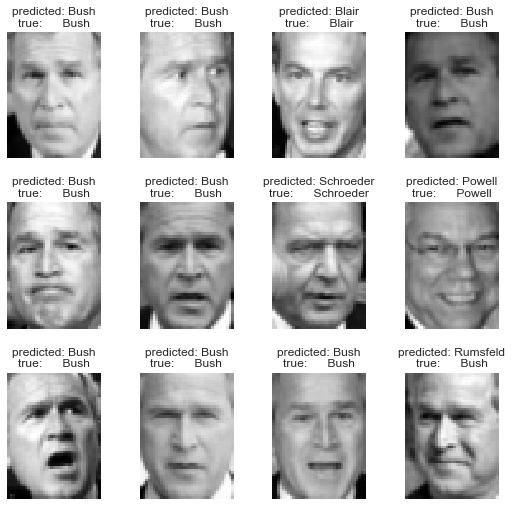

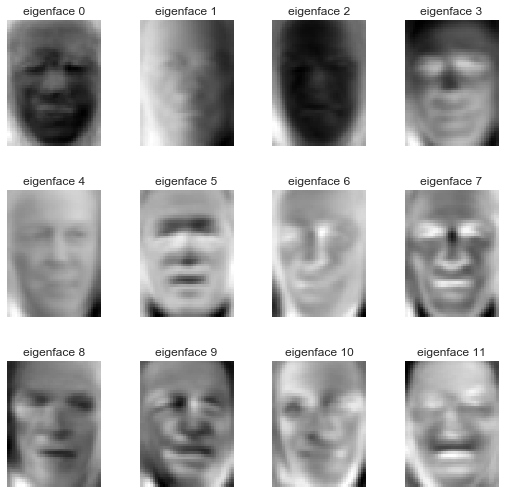

In [39]:
model_ASM = Sequential()
model_ASM.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_ASM.add(Dropout(0.5))
model_ASM.add(Dense(7, activation="softmax"))
model_ASM.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/AnnealingSoftmax/spam20.hdf5')
model_ASM.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_ASM = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## THOMPSON SAMBLING

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.65      0.56      0.60        27
    George W Bush       0.85      0.92      0.88       146
Gerhard Schroeder       0.77      0.68      0.72        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.69      0.61      0.65        36

      avg / total       0.78      0.78      0.77       322

[[  6   4   1   2   0   0   0]
 [  1  50   1   5   1   1   1]
 [  5   3  15   3   0   0   1]
 [  0   4   4 134   0   0   4]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   4   1   6   3   0  22]]


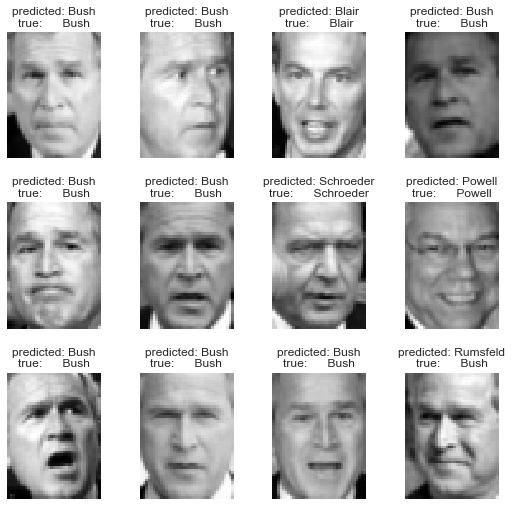

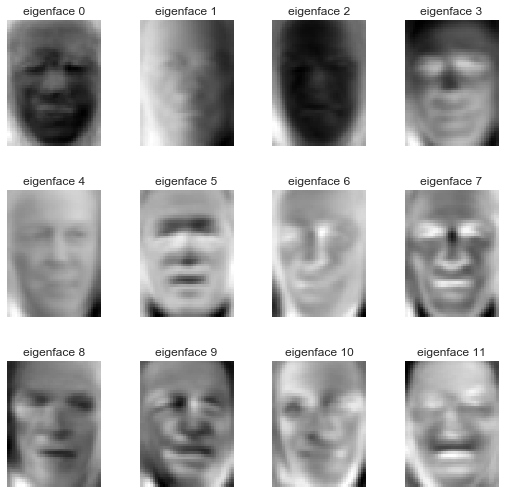

In [40]:
model_TS = Sequential()
model_TS.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_TS.add(Dropout(0.5))
model_TS.add(Dense(7, activation="softmax"))
model_TS.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/thompson_sampling/spam20.hdf5')
model_TS.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_TS = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## HEDGE

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.65      0.56      0.60        27
    George W Bush       0.85      0.92      0.88       146
Gerhard Schroeder       0.77      0.68      0.72        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.69      0.61      0.65        36

      avg / total       0.78      0.78      0.77       322

[[  6   4   1   2   0   0   0]
 [  1  50   1   5   1   1   1]
 [  5   3  15   3   0   0   1]
 [  0   4   4 134   0   0   4]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   4   1   6   3   0  22]]


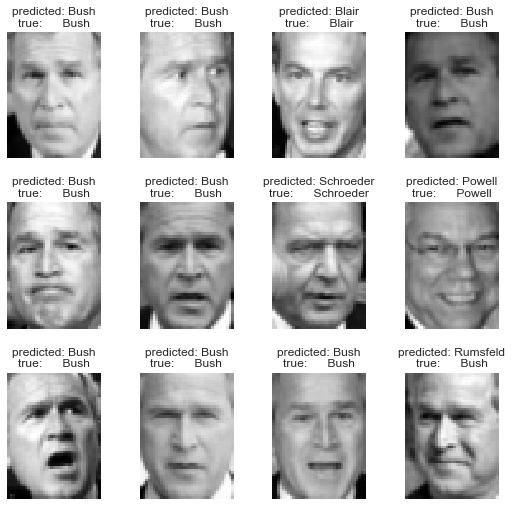

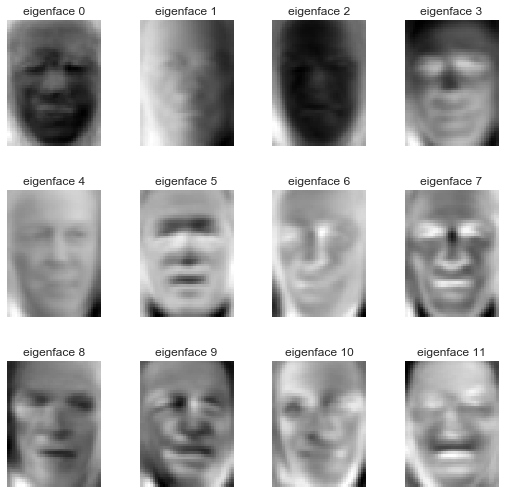

In [41]:
model_HG = Sequential()
model_HG.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_HG.add(Dropout(0.5))
model_HG.add(Dense(7, activation="softmax"))
model_HG.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/Hedge/spam20.hdf5')
model_HG.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_HG = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## EXP3

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.46      0.46      0.46        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.65      0.56      0.60        27
    George W Bush       0.85      0.92      0.88       146
Gerhard Schroeder       0.77      0.68      0.72        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.69      0.61      0.65        36

      avg / total       0.78      0.78      0.77       322

[[  6   4   1   2   0   0   0]
 [  1  50   1   5   1   1   1]
 [  5   3  15   3   0   0   1]
 [  0   4   4 134   0   0   4]
 [  1   0   0   3  17   0   4]
 [  0   2   1   4   1   7   0]
 [  0   4   1   6   3   0  22]]


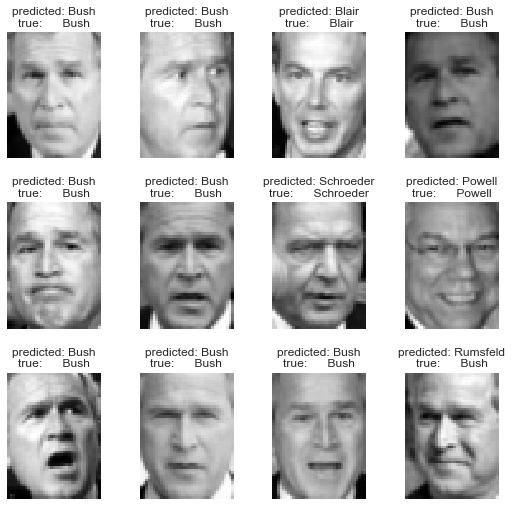

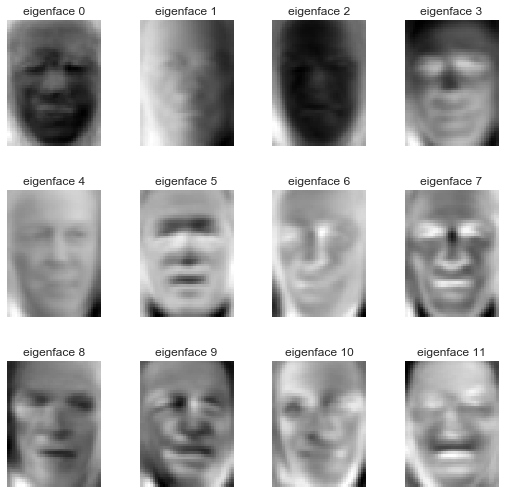

In [42]:
model_EXP = Sequential()
model_EXP.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_EXP.add(Dropout(0.5))
model_EXP.add(Dense(7, activation="softmax"))
model_EXP.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/Exp3/spam20.hdf5')
model_EXP.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_EXP = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()